In [1]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, remesh
from helpers.computational_tools import select_NA, select_Pacific, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
import xarray as xr
from time import time
import json
%load_ext autoreload
%autoreload 3

In [2]:
def sample_grid_harmonic(dataset, key, plain=False):
    '''
    Here for simplicity the dataset is coarsegrained
    snapshot of CM26.
    '''
    data = dataset.data
    ny, nx = data.u.shape
    
    u = np.zeros((ny,nx))
    v = np.zeros((ny,nx))
    
    # assign random phase (1 or -1)
    phase = -1 if np.random.randint(2)==0 else 1
    
    if key == 'vorticity':
        sign = -1
    elif key == 'divergence':
        sign = 1
    else:
        print('Error: key is wrongly specified')
    
    for j in range(ny):
        for i in range(nx):
            if plain:
                idx = i if np.random.randint(2)==0 else j
            else:
                idx = i+j
            u[j,i] = phase *        (-1)**(idx)
            v[j,i] = phase * sign * (-1)**(idx)
            
    data['u'] = xr.DataArray(u, dims=['yh', 'xq']) * dataset.param.wet_u
    data['v'] = xr.DataArray(v, dims=['yq', 'xh']) * dataset.param.wet_v
    return DatasetCM26(data, dataset.param, dataset.grid)

In [3]:
def sample_plane_wave(ny, nx):
        # Sampling frequency between -pi and pi, i.e. all
        # available frequencies
        freq_x = 0
        freq_y = 0
        while np.abs(freq_x)<2/3*np.pi and np.abs(freq_y)<2/3*np.pi:
            # i.e. if wave is inside the square of 2/3*pi,
            # keep sampling
            freq_x = np.random.rand() * np.pi * 2 - np.pi
            freq_y = np.random.rand() * np.pi * 2 - np.pi

        phase_u = np.random.rand()*2*np.pi
        phase_v = np.random.rand()*2*np.pi

        i = np.ones(ny).reshape(-1,1)@np.arange(nx).reshape(1,-1)
        j = np.arange(ny).reshape(-1,1)@np.ones(nx).reshape(1,-1)

        u = np.sin(freq_x * i + freq_y * j + phase_u)
        v = np.sin(freq_x * i + freq_y * j + phase_v)

        return u, v

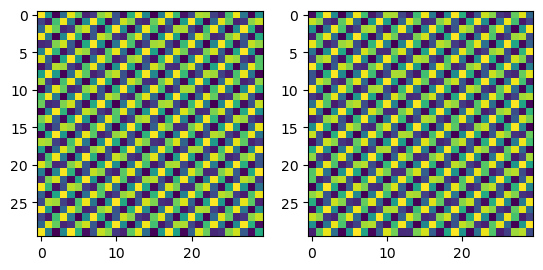

In [4]:
u, v = sample_plane_wave(30,30)
plt.subplot(1,2,1)
plt.imshow(u)
plt.subplot(1,2,2)
plt.imshow(v)

In [5]:
def sample_two_thirds(dataset):
    '''
    Here for simplicity the dataset is coarsegrained
    snapshot of CM26.
    '''        
    
    data = dataset.data
    ny, nx = data.u.shape
    u,v = sample_plane_wave(ny,nx)

    data['u'] = xr.DataArray(u, dims=['yh', 'xq']) * dataset.param.wet_u
    data['v'] = xr.DataArray(v, dims=['yq', 'xh']) * dataset.param.wet_v
    return DatasetCM26(data, dataset.param, dataset.grid)

In [6]:
def perturb_velocities(dataset, amp=1e-2):
    data = dataset.data.copy()
    ny, nx = data.u.shape
    u,v = sample_plane_wave(ny,nx)
    
    data['u'] = data['u'] + amp * xr.DataArray(u, dims=['yh', 'xq']) * dataset.param.wet_u
    data['v'] = data['v'] + amp * xr.DataArray(v, dims=['yq', 'xh']) * dataset.param.wet_v
    
    return DatasetCM26(data, dataset.param, dataset.grid)

In [7]:
ds = DatasetCM26()

In [8]:
training_dataset = ds.sample_epoch(time=np.random.randint(6950))

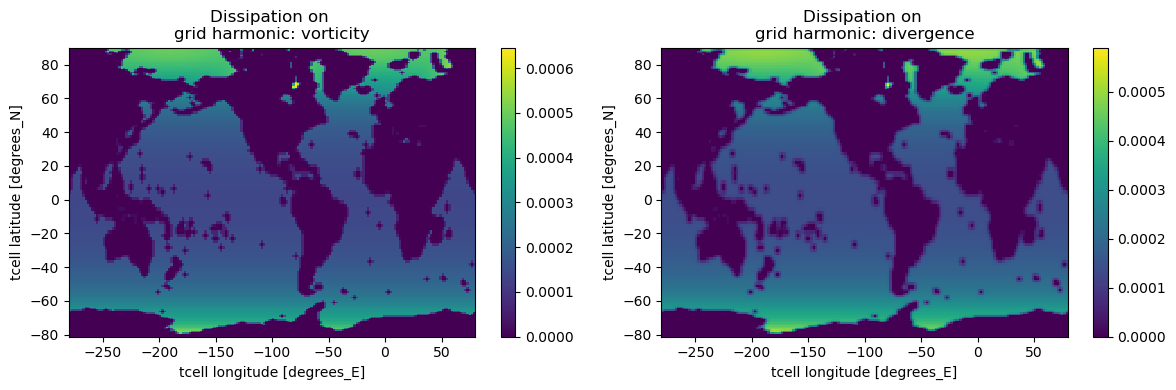

In [9]:
plt.figure(figsize=(12,4))
for j,grid_harmonic in enumerate(['vorticity', 'divergence']):
    batch = sample_grid_harmonic(training_dataset[20],grid_harmonic)
#    batch = sample_two_thirds(training_dataset[20])
    smag = batch.state.Smagorinsky()
    Txx = smag['Txx']
    Tyy = smag['Tyy']
    Txy = smag['Txy']
    sh_xy, sh_xx, vort_xy = batch.state.velocity_gradients()
    dissipation =  Txx * sh_xx + batch.grid.interp(Txy * sh_xy,['X','Y'])
    plt.subplot(1,2,1+j)
    dissipation.plot()
    plt.title(f'Dissipation on \ngrid harmonic: {grid_harmonic}')
plt.tight_layout()

In [10]:
training_dataset[20]

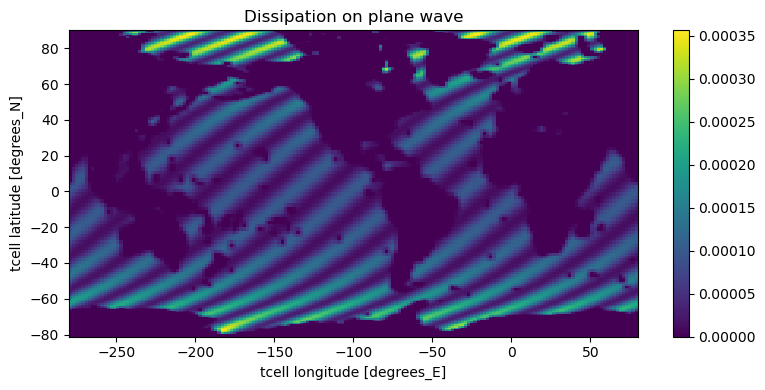

In [11]:
plt.figure(figsize=(8,4))
batch = sample_two_thirds(training_dataset[20])
smag = batch.state.Smagorinsky()
Txx = smag['Txx']
Tyy = smag['Tyy']
Txy = smag['Txy']
sh_xy, sh_xx, vort_xy = batch.state.velocity_gradients()
dissipation =  Txx * sh_xx + batch.grid.interp(Txy * sh_xy,['X','Y'])
dissipation.plot()
plt.title(f'Dissipation on plane wave')
plt.tight_layout()

Text(0.5, 1.0, 'Perturbation')

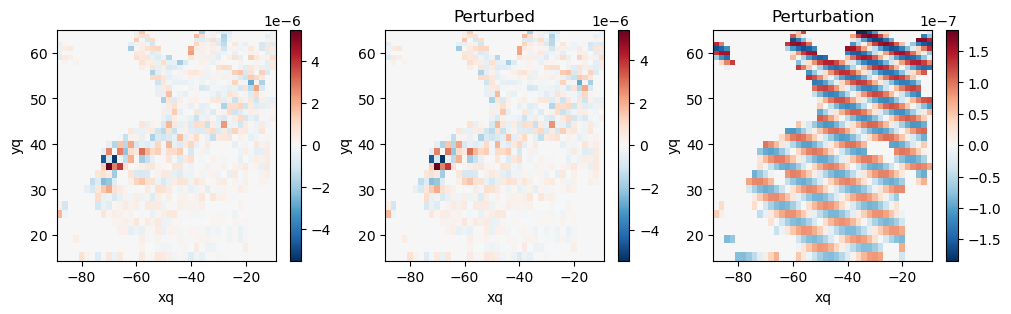

In [12]:
training_dataset = ds.sample_epoch(time=np.random.randint(6950))
batch = training_dataset[20]
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
sh_xx0 = batch.state.velocity_gradients()[0]
plt.title('Initial sh_xx shear')
select_NA(sh_xx0).plot()
plt.subplot(1,3,2)
sh_xx = perturb_velocities(batch,amp=1e-2).state.velocity_gradients()[0]
select_NA(sh_xx).plot()
plt.title('Perturbed')
plt.subplot(1,3,3)
sh_xx = perturb_velocities(batch,amp=1e-2).state.velocity_gradients()[0]
select_NA(sh_xx-sh_xx0).plot()
plt.title('Perturbation')

In [28]:
# ann_Txy = ANN([27, 20, 1])
# ann_Txx_Tyy = ANN([27, 20, 2])
log_dict = {}
ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')

In [29]:
num_epochs=1000

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(num_epochs):
    t_e = time()
    
    training_dataset = ds.sample_epoch(time=np.random.randint(6950)) # Approximately 19 years for training
    testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035)) # Approximately 3 years for testing
    print(f'---------- Epoch {epoch} ------------\n')
    
    for factor in [2,4,6,10,20]:
        ############# Training step ################
        
        optimizer.zero_grad()
        
        batch = training_dataset[factor]
        prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
        ANNx = prediction['ZB20u']
        ANNy = prediction['ZB20v']
        SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
        SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)
        
        SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())
        
        MSE_train = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        # Regulatization by perturbing and computing response
        smag = batch.state.Smagorinsky()
        smagx = torch.tensor(smag['smagx'].values).type(torch.float32)
        smagy = torch.tensor(smag['smagy'].values).type(torch.float32)

        batch_perturbed = perturb_velocities(batch)
        smag = batch_perturbed.state.Smagorinsky()
        smagx_perturbed = torch.tensor(smag['smagx'].values).type(torch.float32)
        smagy_perturbed = torch.tensor(smag['smagy'].values).type(torch.float32)
        smagx_response = smagx_perturbed - smagx
        smagy_response = smagy_perturbed - smagy
        
        prediction = batch_perturbed.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
        ANNx_perturbed = prediction['ZB20u']
        ANNy_perturbed = prediction['ZB20v']
        ANNx_response = ANNx_perturbed - ANNx
        ANNy_response = ANNy_perturbed - ANNy
        
        SGS_norm = 1. / torch.sqrt((smagx_response**2 + smagy_response**2).mean())
        
        MSE_plane_waves = (
            (ANNx_response * SGS_norm - smagx_response * SGS_norm)**2 +
            (ANNy_response * SGS_norm - smagy_response * SGS_norm)**2
        ).mean()
        
        loss = MSE_train + MSE_plane_waves
        
        loss.backward()
        optimizer.step()
        
        del batch_perturbed.data
        
        ############ Testing step ##################
        with torch.no_grad():
            batch = testing_dataset[factor]
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
            ANNx = prediction['ZB20u']
            ANNy = prediction['ZB20v']
            SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
            SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)

            SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())

            MSE_test = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        print(f'Factor: {factor}.' + \
              ' MSE train/test: [%.6f, %.6f]' % (float(MSE_train.data), float(MSE_test.data)) + \
              ' MSE on plane waves: %.6f' % (float(MSE_plane_waves)))
        ########### Saving history of losses ############
        log_dict[f'epoch-{epoch+1}-factor-{factor}'] = \
            dict(MSE_train=float(MSE_train.data),
                 MSE_test=float(MSE_test.data),
                 MSE_plane_waves=float(MSE_plane_waves)
                )
        ######## Freeing memory ############
        del training_dataset[factor].data
        del training_dataset[factor].param
        del testing_dataset[factor].data
        del testing_dataset[factor].param
    t = time()
    print('Epoch time/Remaining time in seconds: [%d/%d]' % (t-t_e, (t-t_s)*(num_epochs/(epoch+1)-1)))
    scheduler.step()    
    
    if (epoch+1) % 50 == 0:
        export_ANN(ann_Txy, input_norms=torch.ones(27), output_norms=torch.ones(1), 
           filename=f'trained_models/ANN_CM26_grid_harmonic_ver3/Txy_epoch_{epoch+1}.nc')
        export_ANN(ann_Txx_Tyy, input_norms=torch.ones(27), output_norms=torch.ones(2), 
           filename=f'trained_models/ANN_CM26_grid_harmonic_ver3/Txx_Tyy_epoch_{epoch+1}.nc')
        with open(f'trained_models/ANN_CM26_grid_harmonic_ver3/log_dict_epoch_{epoch+1}', 'w') as file:
            json.dump(log_dict, file)

---------- Epoch 0 ------------

Factor: 2. MSE train/test: [0.613465, 0.626957] MSE on plane waves: 1.112745
Factor: 4. MSE train/test: [0.541300, 0.558200] MSE on plane waves: 1.064974
Factor: 6. MSE train/test: [0.580507, 0.599920] MSE on plane waves: 1.058999
Factor: 10. MSE train/test: [0.688538, 0.701487] MSE on plane waves: 0.989176
Factor: 20. MSE train/test: [0.892305, 0.919077] MSE on plane waves: 0.953884
Epoch time/Remaining time in seconds: [21/21469]
---------- Epoch 1 ------------

Factor: 2. MSE train/test: [0.610532, 0.625302] MSE on plane waves: 0.892761
Factor: 4. MSE train/test: [0.573668, 0.589493] MSE on plane waves: 1.028998
Factor: 6. MSE train/test: [0.616896, 0.633833] MSE on plane waves: 0.792512
Factor: 10. MSE train/test: [0.718306, 0.732814] MSE on plane waves: 0.920112
Factor: 20. MSE train/test: [0.937685, 0.923940] MSE on plane waves: 1.012636
Epoch time/Remaining time in seconds: [19/20237]
---------- Epoch 2 ------------

Factor: 2. MSE train/test: [0

# Check dissipation pattern for trained ANN

In [14]:
# ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
# ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')
ann_Txy = import_ANN('trained_models/ANN_CM26_grid_harmonic_ver3/Txy_epoch_1000.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_grid_harmonic_ver3/Txx_Tyy_epoch_1000.nc')

In [15]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))

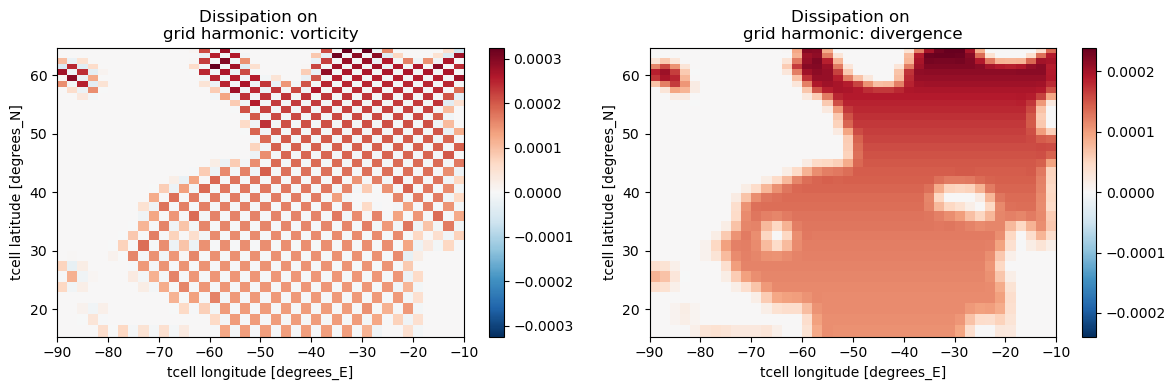

In [17]:
plt.figure(figsize=(12,4))
import cmocean
for j,grid_harmonic in enumerate(['vorticity', 'divergence']):
    batch = sample_grid_harmonic(testing_dataset[20],grid_harmonic,plain=False)
    zb = batch.state.ANN(ann_Txy, ann_Txx_Tyy)
#    zb = batch.state.Smagorinsky()
    dissipation =  zb['Txx'] * zb['sh_xx'] + batch.grid.interp(zb['Txy'] * zb['sh_xy'],['X','Y'])
    plt.subplot(1,2,1+j)
    select_NA(dissipation).plot()
    plt.title(f'Dissipation on \ngrid harmonic: {grid_harmonic}')
plt.tight_layout()

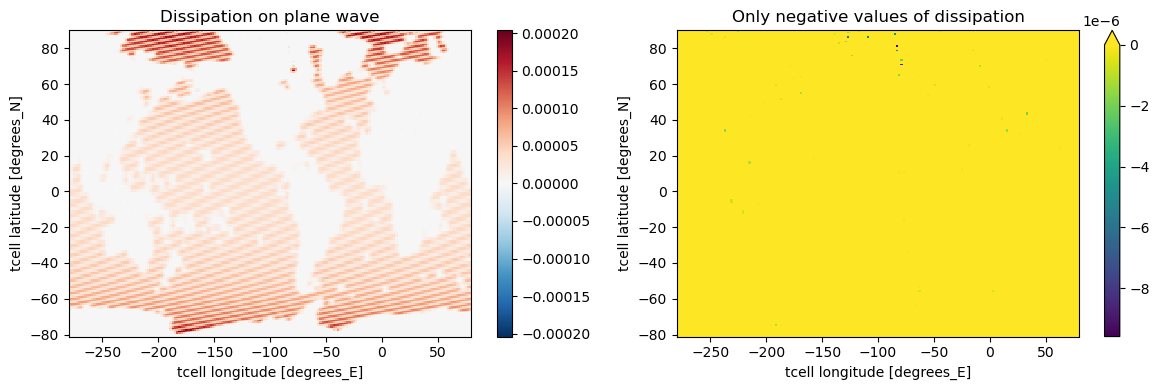

In [28]:
plt.figure(figsize=(12,4))
batch = sample_two_thirds(testing_dataset[20])
zb = batch.state.ANN(ann_Txy, ann_Txx_Tyy)
dissipation =  zb['Txx'] * zb['sh_xx'] + batch.grid.interp(zb['Txy'] * zb['sh_xy'],['X','Y'])
plt.subplot(1,2,1)
(dissipation).plot()
plt.title(f'Dissipation on plane wave')
plt.subplot(1,2,2)
(dissipation).plot(vmax=0)
plt.title('Only negative values of dissipation')
plt.tight_layout()

# Check pointwise prediction

Correlation: 0.5617098947560792
Relative Error: 0.9277958477431285
R2 =  0.3141243476715062
R2 max =  0.3154947579223323
Optinal scaling: 0.9381684612625195
Nans: 0
Correlation: 0.3950713605801982
Relative Error: 0.9642467935835142
R2 =  0.15246623693335815
R2 max =  0.15602715996260796
Optinal scaling: 0.8687561180612663
Nans: 0
Correlation: 0.19410760291029083
Relative Error: 1.0289280206496325
R2 =  -0.030007217518437823
R2 max =  0.03756493565274843
Optinal scaling: 0.42713194365949175
Nans: 0


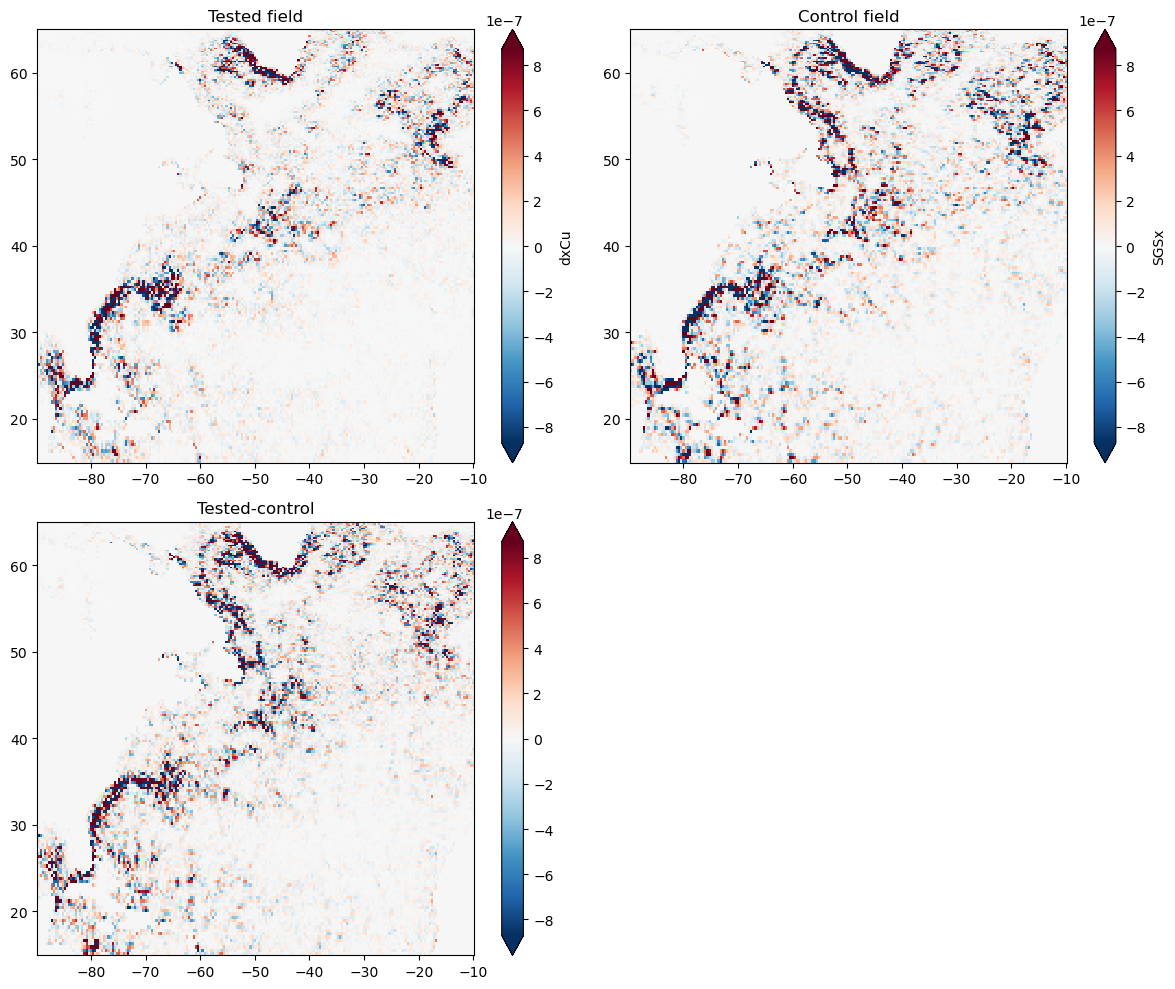

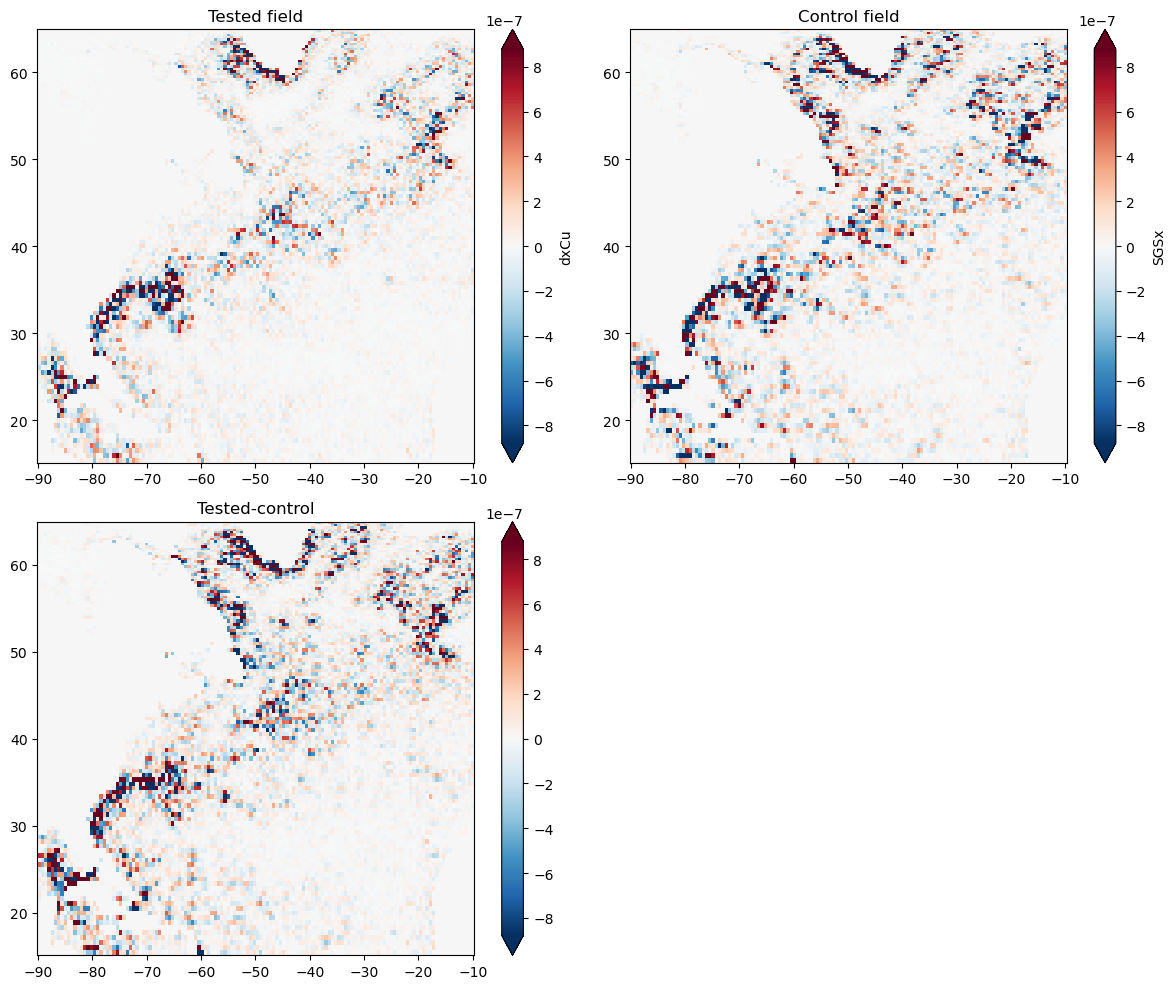

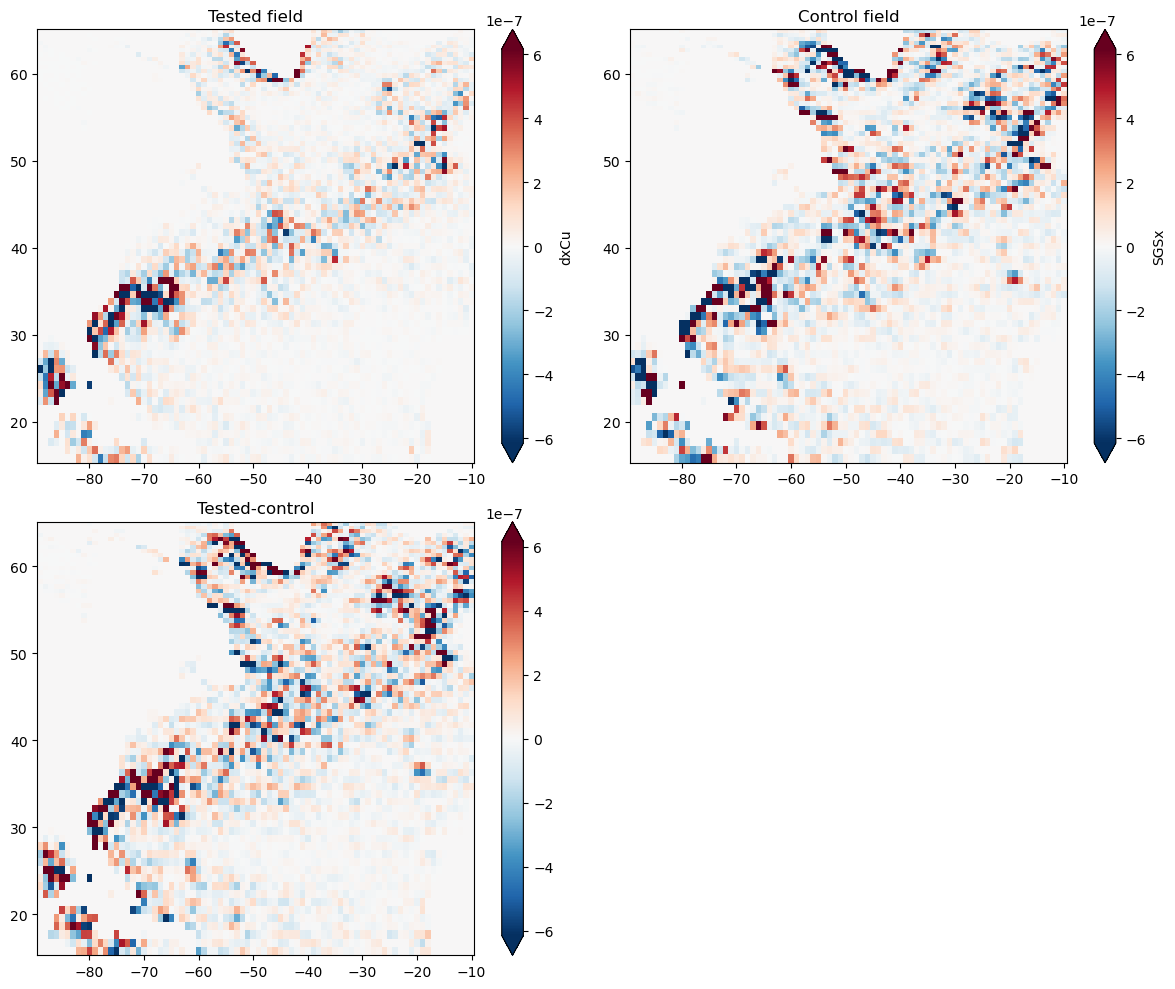

In [30]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [4,6,10]:
    data = testing_dataset[factor].data
    compare(testing_dataset[factor].state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20u'], data.SGSx)

Correlation: 0.491248601054708
Relative Error: 0.925628311481033
R2 =  0.2188089212151515
R2 max =  0.2413216264595035
Optinal scaling: 0.7660294536336756
Nans: 0
Correlation: 0.5010089082541015
Relative Error: 0.9327700231245204
R2 =  0.23544851614416806
R2 max =  0.2509884482633099
Optinal scaling: 0.8007513559104452
Nans: 0
Correlation: 0.30347127177525146
Relative Error: 1.0064085750682215
R2 =  0.022193260652622615
R2 max =  0.09209088481690664
Optinal scaling: 0.5344135426483816
Nans: 0


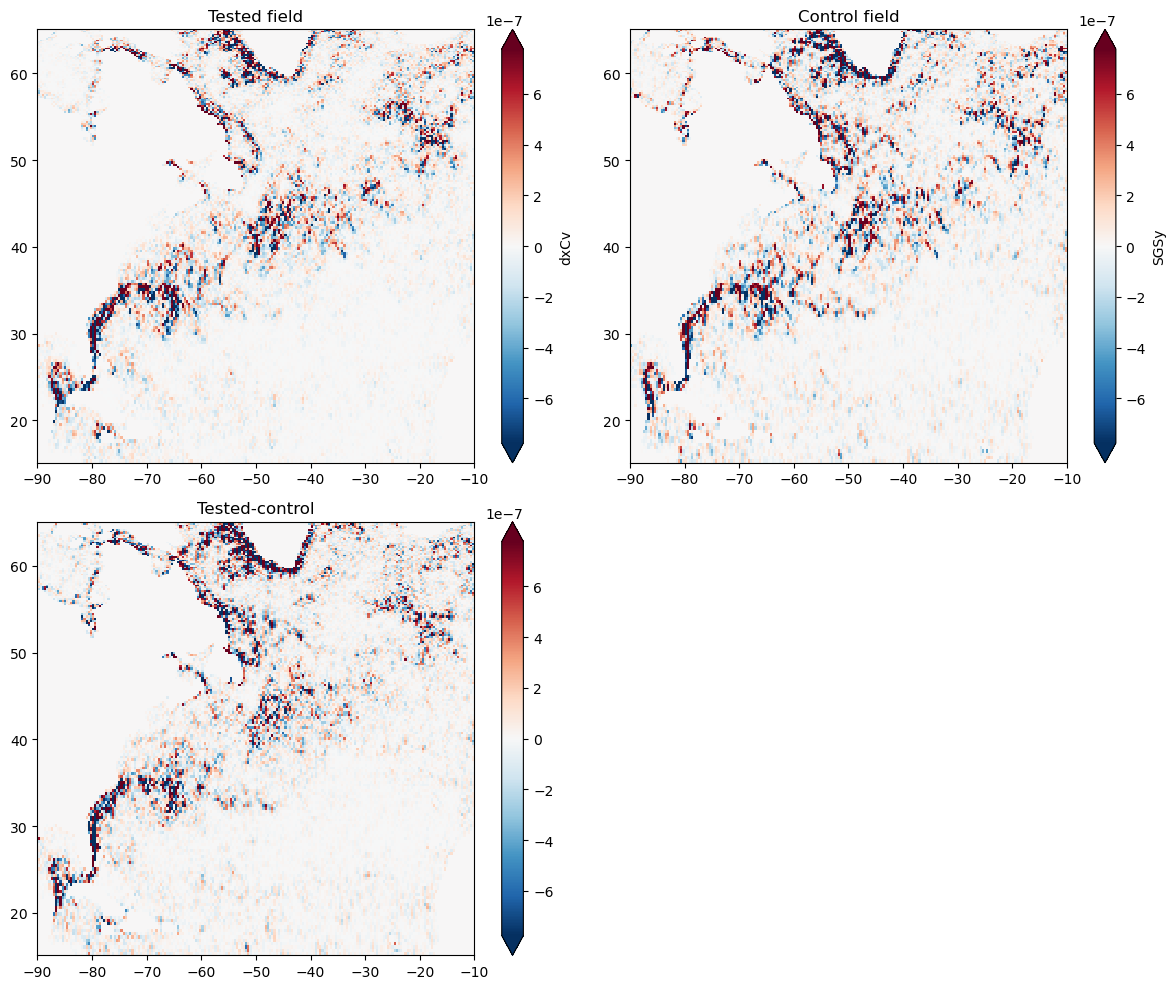

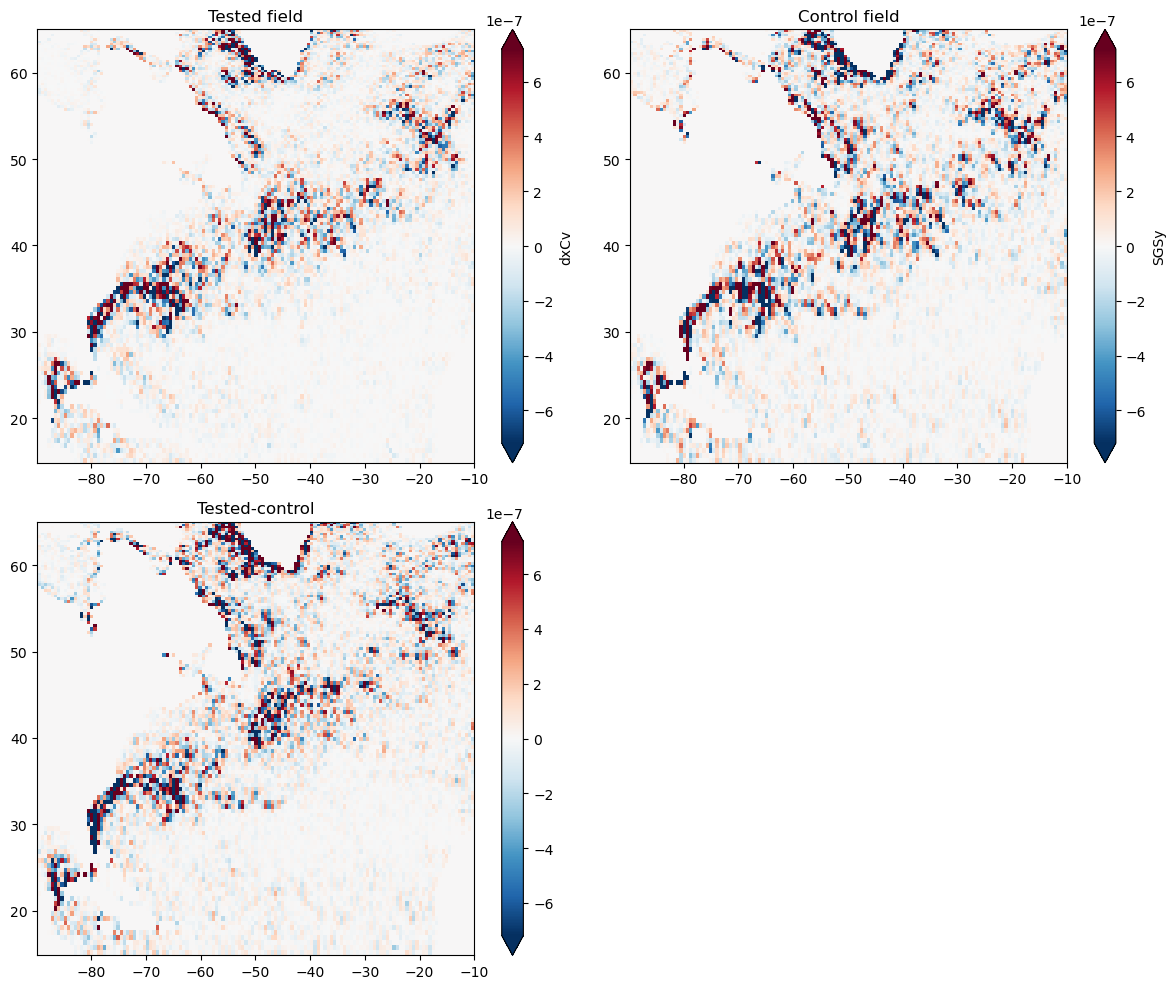

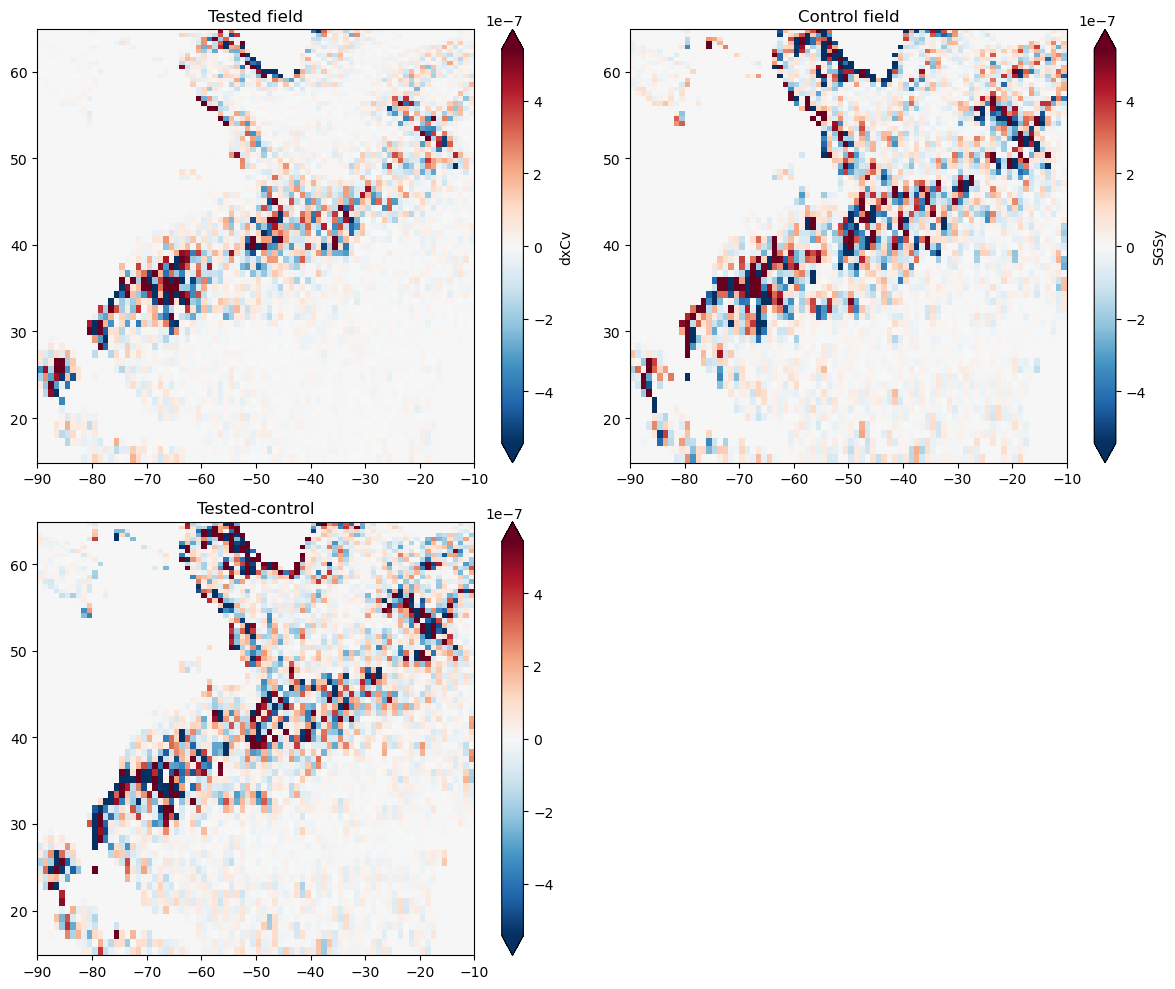

In [31]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [4,6,10]:
    data = testing_dataset[factor].data
    compare(testing_dataset[factor].state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20v'], data.SGSy)